# Libraries Used

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# To prepare data sets
from sklearn.model_selection import train_test_split

# Confusion matrix, metrics
from sklearn.metrics import confusion_matrix

# To plot the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from time import gmtime, strftime

# The code base

from discretization import make_cube, load_nparray, is_positive
from settings import progress, extract_id, extracted_protein_suffix,training_examples_folder, \
extracted_ligand_suffix, extracted_data_test_folder, resolution_cube, nb_neg_ex_per_pos
from settings import progress

# Models created
from models import first_model

/home/jsquared/.local/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Functions

Here, we define some functions to create cubes and the rest.

In [2]:
def get_cubes(nb_examples=128):
    """
    Return the first nb_examples cubes with their ys.
    :param nb_examples: 
    :return: list of cubes and list of their ys
    """
    examples_files = sorted(os.listdir(training_examples_folder))[0:nb_examples]

    cubes = []
    ys = []
    for index, ex_file in enumerate(examples_files):
        file_name = os.path.join(training_examples_folder, ex_file)
        example = load_nparray(file_name)

        cube = make_cube(example, resolution_cube)
        y = 1 * is_positive(ex_file)

        cubes.append(cube)
        ys.append(y)

    # Conversion to np.ndarrays with the first axes used for examples
    cubes = np.array(cubes)
    ys = np.array(ys)
    assert(ys.shape[0] == nb_examples)
    assert(cubes.shape[0] == nb_examples)

    return cubes, ys

In [3]:
def examples_iterator(data_folder) -> (np.ndarray, str, str):
    """
    Construct all the examples in the given folder

    :param data_folder:
    :return: a example (cube) at the time with the system used to construct the cube
    """
    # Getting all the systems
    list_systems_ids = set(list(map(extract_id, os.listdir(data_folder))))

    # For each system, we create the associated positive example and we generate some negative examples
    for system_id in progress(sorted(list_systems_ids)):
        protein = load_nparray(os.path.join(data_folder, system_id + extracted_protein_suffix))
        ligand = load_nparray(os.path.join(data_folder, system_id + extracted_ligand_suffix))

        # Yielding first positive example
        positive_example = np.concatenate((protein, ligand), axis=0)
        cube_pos_example = make_cube(positive_example, resolution_cube)
        yield cube_pos_example, system_id, system_id

        # Yielding all the others negatives examples with the same protein
        others_system = sorted(list(list_systems_ids.difference(set(system_id))))
        for other_system in others_system:
            bad_ligand = load_nparray(os.path.join(data_folder, other_system + extracted_ligand_suffix))

            # Saving negative example
            negative_example = np.concatenate((protein, bad_ligand), axis=0)
            cube_neg_example = make_cube(negative_example, resolution_cube)
            yield cube_neg_example, system_id, other_system

# Choice of the model

Here, we can choose the model we would like to use for predicting the binding between protein and ligands.

In [4]:
# Choosing the model
model = first_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 28, 28, 28, 32)    3488      
_________________________________________________________________
flatten_1 (Flatten)          (None, 702464)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                63221850  
_________________________________________________________________
dense_2 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 63,232,659
Trainable params: 63,232,659
Non-trainable params: 0
________________________________________________________________

In [5]:
# We are taking systems of the first 200 proteins (pos and neg example)
nb_examples = 200 * (1 + nb_neg_ex_per_pos)
cubes, ys = get_cubes(nb_examples)
print("Done loading dataset")

Done loading dataset


In [7]:
assert(len(cubes) == nb_examples)
nb_pos_examples = len(list(filter(lambda x: x==1, ys)))
nb_neg_examples = len(list(filter(lambda x: x==0, ys)))
print(f"{nb_pos_examples} positive examples")
print(f"{nb_neg_examples} negative examples")

201 positive examples
1999 negative examples


In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# To have the F1-score printed during training
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        f1 = f1_score(val_targ, val_predict)
        ecall = recall_score(val_targ, val_predict)
        precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)
        print(f"— f1: {f1} — precision: {precision} — recall: {recall}")
        return

metrics = Metrics()

In [13]:
# Training the network
history = model.fit(cubes, ys)

Epoch 1/1
2200/2200 [==============================] - 516s 234ms/step - loss: 0.0947 - acc: 0.8995 - mean_pred: 0.0079


In [11]:
# Saving the model
from settings import models_folders
current_datetime = strftime("%Y-%m-%d-%H:%M:%S", gmtime())
model.save(os.path.join(models_folders, current_datetime + 'first_model.h5'))

OSError: Unable to create file (unable to open file: name = 'models/2018-09-30-08:31:49first_model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

# Analysis of the results

After having trained the model, we can analyse how it performs.
We can first plot the evolution of the accuracy for the different epochs.


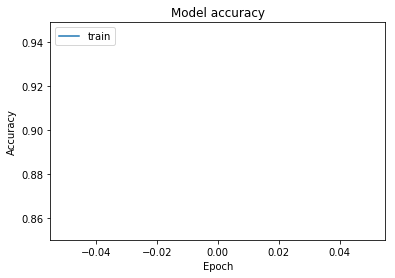

In [54]:
# Summarize history for Accuracy
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can then test the model on the testing set.

In [94]:
def get_cubes_testing(nb_examples=128):
    """
    Return the first nb_examples cubes for testing with their ys.
    :param nb_examples: 
    :return: list of cubes and list of their ys
    """
    counter = 1
    cubes = []
    ys = []
    protein_ids = []
    ligand_ids = []
    for cube, protein_id, ligand_id in progress(examples_iterator(extracted_data_test_folder)):
        counter +=1
        y = 1 * (protein_id == ligand_id)
        protein_ids.append(protein_id)
        ligand_ids.append(ligand_id)
        cubes.append(cube)
        ys.append(y)
        if counter > nb_examples:
            break

    # Conversion to np.ndarrays with the first axes used for examples
    cubes = np.array(cubes)
    ys = np.array(ys)
    protein_ids = np.array(protein_ids)
    ligand_ids = np.array(ligand_ids)
    assert(ys.shape[0] == nb_examples)
    assert(cubes.shape[0] == nb_examples)

    return cubes, ys, protein_ids, ligand_ids

In [95]:
cubes_test, ys, protein_ids, ligand_ids = get_cubes_testing()

In [98]:
ligand_ids

array(['0010', '0010', '0012', '0015', '0022', '0025', '0044', '0051',
       '0053', '0058', '0070', '0076', '0096', '0097', '0099', '0113',
       '0115', '0118', '0123', '0140', '0142', '0149', '0176', '0177',
       '0192', '0222', '0225', '0240', '0243', '0245', '0251', '0256',
       '0260', '0261', '0263', '0284', '0295', '0299', '0301', '0315',
       '0319', '0327', '0345', '0350', '0364', '0367', '0379', '0396',
       '0418', '0424', '0454', '0458', '0464', '0466', '0483', '0494',
       '0510', '0543', '0557', '0560', '0589', '0592', '0613', '0617',
       '0620', '0625', '0627', '0631', '0647', '0648', '0658', '0663',
       '0680', '0699', '0705', '0712', '0724', '0732', '0733', '0738',
       '0739', '0758', '0761', '0802', '0813', '0814', '0825', '0833',
       '0839', '0842', '0849', '0856', '0859', '0863', '0878', '0908',
       '0921', '0943', '0970', '0974', '0983', '0989', '1012', '1015',
       '1039', '1042', '1046', '1047', '1050', '1053', '1064', '1074',
      

In [102]:
cubes_test.shape

(128, 30, 30, 30, 4)

In [104]:
preds = model.predict(cubes_test)

In [105]:
y_preds = np.array(list(map(lambda x: x[0], preds)))
y_preds

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5491193e-38, 0.0000000e+00, 2.3506386e-22, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.9979801e-37,
       0.0000000e+00, 4.8931038e-28, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 4.4346310e-38, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.1959399e-22, 0.0000000e+00, 0.0000000e

## Rounding procedure for prediction

`y_preds` contains floating number between 0 and 1. 
We can use several rounding methods to get numbers in {0,1}:
 - the default one that round each number to its closest integer (the threshold is thus 0.5)
 - another one that set the number to 1 it is doesn't equal 0 (the threshild is here really small)

In [109]:
# Rounding the prediction : using the second one
y_rounded = np.array([1 if y!= 0 else 0 for y in y_preds])

#y_rounded = np.rint(y_preds)

In [110]:
len(y_rounded)

128

## Confusion Matrix

We can plot the confusion matrix that shows the distribution of prediction for positive 

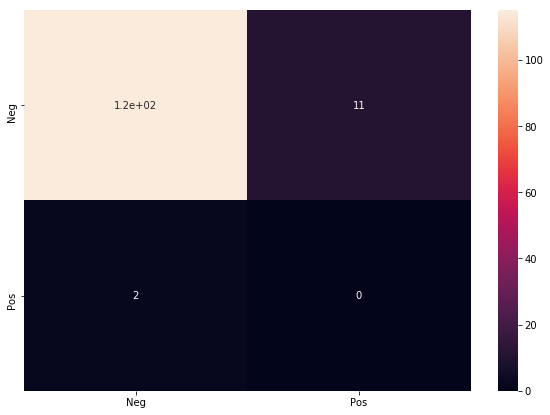

In [111]:
conf_matrix = confusion_matrix(ys, y_rounded)

df_cm = pd.DataFrame(conf_matrix, index = ["Neg", "Pos"],
                  columns = ["Neg", "Pos"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [112]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
print(f"F1 score : {f1_score(ys,y_rounded)}")
print(f"Accuracy score : {accuracy_score(ys,y_rounded)}")
print(f"Precision score : {precision_score(ys,y_rounded)}")
print(f"Recall score : {recall_score(ys,y_rounded)}")

F1 score : 0.0
Accuracy score : 0.8984375
Precision score : 0.0
Recall score : 0.0


In [51]:
# Counting non negative predictions
len(list(filter(lambda x: x!= 0, y_preds)))

1100

In [21]:
ys

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
